In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random as rn
from os.path import join, getsize
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.style as style


from PIL import Image
from tqdm import tqdm

setting dynamic memory

In [39]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#InteractiveSession().close

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

c:\Users\lioma\anaconda3\envs\tensorflow_3\lib\site-packages\tensorflow\python\client\session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Load Dataset

In [40]:
BATCH_SIZE = 32
CHANNELS = 3
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_SIZE=(IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE=IMG_SIZE + (3,)  # --> (224,224,3)
NUM_CLASSES=3
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024

Utilities

In [41]:
def reset_random_seed():
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]=str(2)

  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(2)

  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(2)

  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(2)
  

def get_dataset(path, img_size = IMG_SIZE, batch_size = BATCH_SIZE):
    """ Get the dataset given the directory name.
    Args:
    - apth (str): a string representing the name of the directory from which the dataset is retrieved.
    
    Returns:
    - ds (PrefetchDataset): a Dataset containing the elements in the directory.
  """
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        seed = 2,
        image_size = img_size,
        batch_size = batch_size
    )


def show_history_fit(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(9, 9))
  plt.subplot(2, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='upper right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


def compile_model(model, optimizer = 'adam', learning_rate = 0.0001):

  if optimizer == 'rmsprop':
    model.compile(
      optimizer = tf.keras.optimizers.RMSprop(learning_rate),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = ['accuracy']
    )
  elif optimizer == 'adam':
    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = ['accuracy']
    )
  
  model.summary()


def fit_model(model, train, validation, path_model, epochs_par = 30, patience_par = 6):

  earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience= patience_par, verbose=1)

  checkpoint = ModelCheckpoint(path_model,   
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
  )

  history = model.fit(train, epochs= epochs_par,
                        validation_data=validation,
                        verbose=1,
                        shuffle=True, 
                        callbacks=[earlystopping, checkpoint])

  return history, model


def load_best_model_and_evaluate(path, test, optimizer = 'adam', learning_rate = 0.0001, compile = False):

  model = tf.keras.models.load_model(path)

  if compile:
    compile_model(model, optimizer, learning_rate)

  model.evaluate(test)


  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = 1))

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  print(predicted_labels)
  print(correct_labels)

  print("Classification report: ")
  print(metrics.classification_report(correct_labels,predicted_labels,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)


def plot_class_distribution(path, name):
  """ Plot in a bar char the class distribution of data contained in the directory passed as parameter."""
  
  classes = [name for name in os.listdir(path)] 
  class_distribution = {}
  for dir in classes:
    CURR_DIR = path + "/" + dir
    class_distribution[dir] = len([name for name in os.listdir(CURR_DIR) if os.path.isfile(os.path.join(CURR_DIR, name))])

  total = 0
  for class_ in class_distribution:
    print(f'{class_}: {class_distribution[class_]}')
    total += class_distribution[class_]

  print()
  print(f'Total:{total}')

  fig, axes = plt.subplots(figsize=(10,len(class_distribution)))
  plt.bar(class_distribution.keys(), height=class_distribution.values())
  plt.title(f'Barplot of class distribution of {name} dataset');

def confusion_matrix():
  return 'TO DO'
  

In [42]:
path_dataset = './dataset_splitted_balanced/'
path_train = path_dataset + 'train/'
path_validation = path_dataset + 'validation/'
path_test = path_dataset + 'test/'


In [43]:
reset_random_seed()
train_ds = get_dataset(path_train)
val_ds = get_dataset(path_validation)
test_ds = get_dataset(path_test)

Found 60120 files belonging to 3 classes.
Found 12004 files belonging to 3 classes.
Found 12005 files belonging to 3 classes.


Miscellanous: 20040
Negative: 20040
Positive: 20040

Total:60120
Miscellaneous: 1432
Negative: 4878
Positive: 5694

Total:12004
Miscellaneous: 1473
Negative: 4858
Positive: 5674

Total:12005


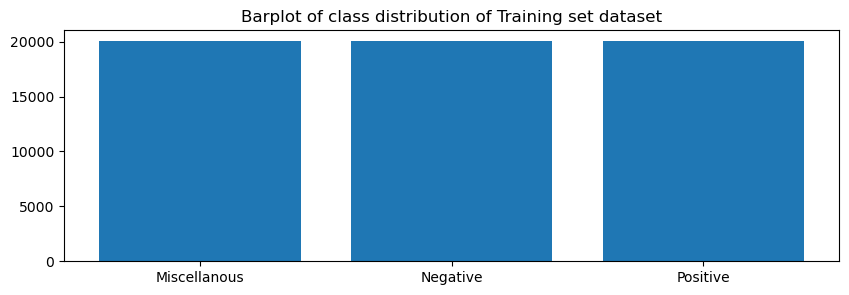

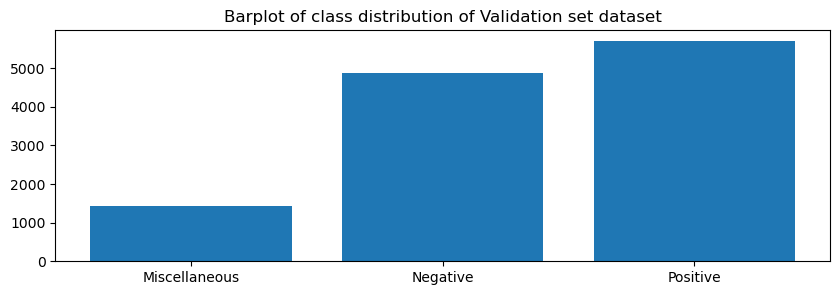

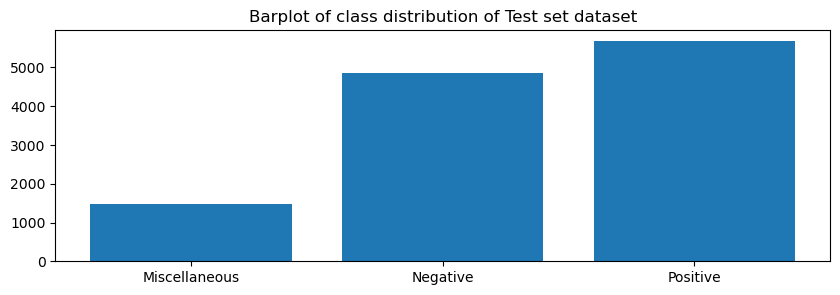

In [44]:
plot_class_distribution(path_train, 'Training set')

plot_class_distribution(path_validation, 'Validation set')

plot_class_distribution(path_test, 'Test set')

In [45]:
print(train_ds.class_names)


['Miscellanous', 'Negative', 'Positive']


tf.Tensor([2 0 0 2 0 1 0 1 0 2 1 0 2 2 0 2 2 1 1 0 2 0 2 2 0 1 1 1 0 0 1 1], shape=(32,), dtype=int32)


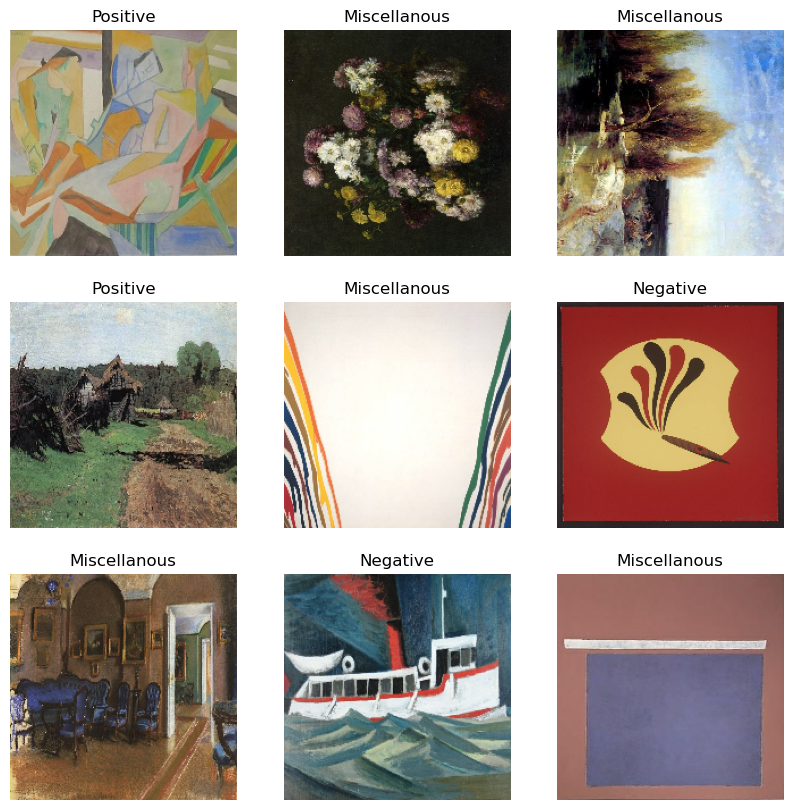

In [53]:
#visualize train samples
tf.random.set_seed(123)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(labels)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [10]:
#train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size = AUTOTUNE)
#val_ds = val_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size = AUTOTUNE)
#test_ds = test_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size = AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

## SCRATCH CNN

### Experiment 0

Tiny example

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((5, 5))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((5, 5))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)#x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                         

In [13]:
path_model = './new_models_sc/ex0_extrabatch_2_scratch_32_128_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
1879/1879 [==============================] - ETA: 0s - loss: 1.0570 - accuracy: 0.4385
Epoch 00001: val_loss improved from inf to 1.03901, saving model to ./new_models_sc\ex0_extrabatch_2_scratch_32_128_epoch_30_adam_1e-4.h5
1879/1879 [==============================] - 246s 128ms/step - loss: 1.0570 - accuracy: 0.4385 - val_loss: 1.0390 - val_accuracy: 0.4598
Epoch 2/30
1878/1879 [============================>.] - ETA: 0s - loss: 1.0258 - accuracy: 0.4779
Epoch 00002: val_loss improved from 1.03901 to 1.03890, saving model to ./new_models_sc\ex0_extrabatch_2_scratch_32_128_epoch_30_adam_1e-4.h5
1879/1879 [==============================] - 251s 133ms/step - loss: 1.0258 - accuracy: 0.4779 - val_loss: 1.0389 - val_accuracy: 0.4733
Epoch 3/30
1878/1879 [============================>.] - ETA: 0s - loss: 1.0060 - accuracy: 0.4974
Epoch 00003: val_loss improved from 1.03890 to 1.02901, saving model to ./new_models_sc\ex0_extrabatch_2_scratch_32_128_epoch_30_adam_1e-4.h5
1879/1879 

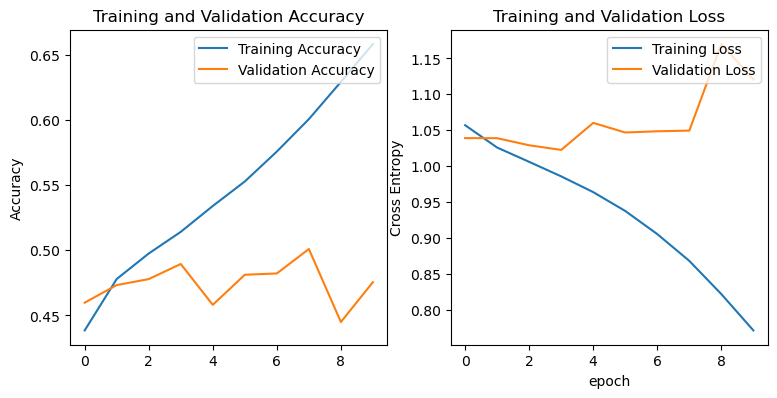

In [14]:
show_history_fit(history)

376/376 [==============================] - 33s 86ms/step - loss: 1.0236 - accuracy: 0.4769
tf.Tensor([2 0 2 ... 2 0 1], shape=(12005,), dtype=int64)
tf.Tensor([1 2 2 ... 2 2 1], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1660    0.2661    0.2045      1473
           1     0.5114    0.5673    0.5379      4858
           2     0.6056    0.4542    0.5191      5674

    accuracy                         0.4769     12005
   macro avg     0.4277    0.4292    0.4205     12005
weighted avg     0.5136    0.4769    0.4881     12005



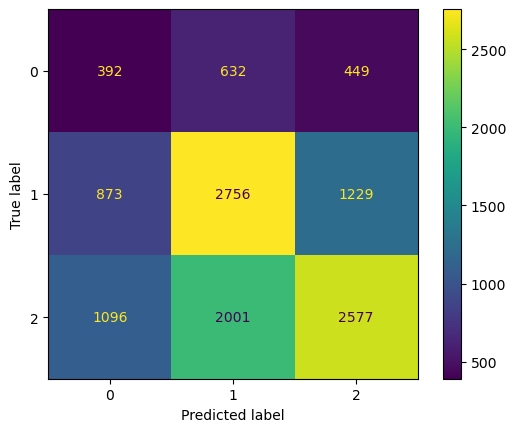

In [15]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 1

In [18]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)


x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu'))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(2048, (3, 3), activation='relu'))
x = layers.Flatten()(x)
#model_m.add(layers.Dropout(0.2))
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [19]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

In [20]:
path_model = './new_models_sc/ex1_extra_2_scratch_32_2x256_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.4385
Epoch 00001: val_loss improved from inf to 1.06249, saving model to ./new_models_sc\ex1_extra_2_scratch_32_2x256_epoch_30_adam_1e-4.h5
940/940 [==============================] - 307s 169ms/step - loss: 1.0573 - accuracy: 0.4385 - val_loss: 1.0625 - val_accuracy: 0.4342
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.0301 - accuracy: 0.4748
Epoch 00002: val_loss improved from 1.06249 to 1.03366, saving model to ./new_models_sc\ex1_extra_2_scratch_32_2x256_epoch_30_adam_1e-4.h5
940/940 [==============================] - 266s 151ms/step - loss: 1.0301 - accuracy: 0.4748 - val_loss: 1.0337 - val_accuracy: 0.4751
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.4934
Epoch 00003: val_loss did not improve from 1.03366
940/940 [==============================] - 273s 157ms/step - loss: 1.0128 - accuracy: 0.4934 - val_loss: 1.0381 - val

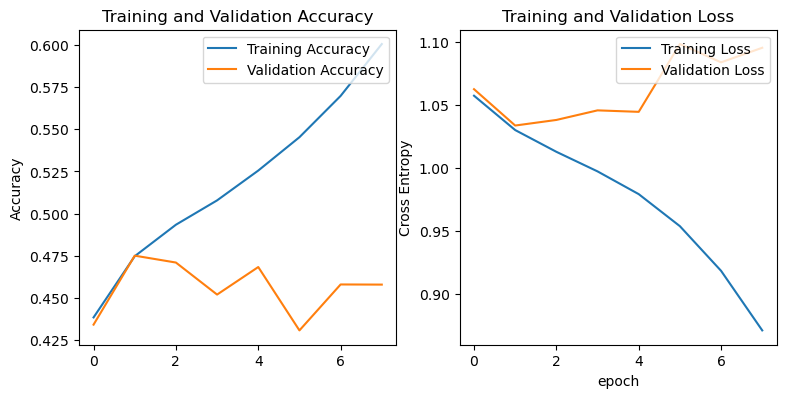

In [21]:
show_history_fit(history)

In [ ]:
#y_pred = model_fitted.predict(test_ds)
#y_pred
#p = np.argmax(y_pred, axis=1)

In [ ]:
#p

188/188 [==============================] - 38s 40ms/step - loss: 1.0354 - accuracy: 0.4689
tf.Tensor([0 1 0 ... 1 1 0], shape=(12005,), dtype=int64)
tf.Tensor([1 1 1 ... 2 2 0], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1563    0.2872    0.2024      1473
           1     0.5271    0.4409    0.4802      4858
           2     0.5851    0.5398    0.5616      5674

    accuracy                         0.4688     12005
   macro avg     0.4228    0.4226    0.4147     12005
weighted avg     0.5090    0.4688    0.4846     12005



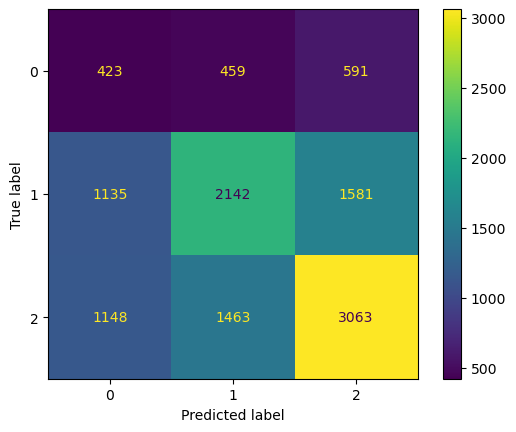

In [22]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 2

Add Dense Layer and Dropout

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.Conv2D(1024, (3, 3), activation='relu', padding='same'))
#model_m.add(layers.MaxPooling2D((2, 2)))
#model_m.add(layers.Conv2D(2048, (3, 3), activation='relu'))
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

In [ ]:
path_model = './new_models_sc/ex2_scratch_32_2x256_512_dp_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 1.0602 - accuracy: 0.4340
Epoch 00001: val_loss improved from inf to 1.00927, saving model to ./new_models_sc\ex2_scratch_32_2x256_512_dp_epoch_30_adam_1e-4.h5
940/940 [==============================] - 142s 135ms/step - loss: 1.0602 - accuracy: 0.4340 - val_loss: 1.0093 - val_accuracy: 0.5062
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.0273 - accuracy: 0.4761
Epoch 00002: val_loss did not improve from 1.00927
940/940 [==============================] - 142s 136ms/step - loss: 1.0273 - accuracy: 0.4761 - val_loss: 1.0441 - val_accuracy: 0.4518
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.4989
Epoch 00003: val_loss did not improve from 1.00927
940/940 [==============================] - 142s 135ms/step - loss: 1.0057 - accuracy: 0.4989 - val_loss: 1.0416 - val_accuracy: 0.4764
Epoch 4/30
940/940 [==============================] - ETA: 0s - loss: 0

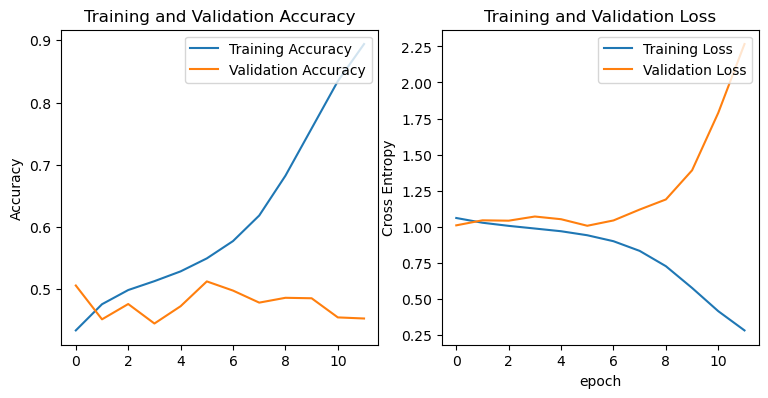

In [ ]:
show_history_fit(history)

188/188 [==============================] - 23s 50ms/step - loss: 1.0141 - accuracy: 0.5020
tf.Tensor([1 2 1 ... 2 0 1], shape=(12005,), dtype=int64)
tf.Tensor([2 2 1 ... 1 1 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1578    0.1887    0.1719      1473
           1     0.5207    0.5762    0.5471      4858
           2     0.6058    0.5197    0.5595      5674

    accuracy                         0.5020     12005
   macro avg     0.4281    0.4282    0.4261     12005
weighted avg     0.5164    0.5020    0.5069     12005



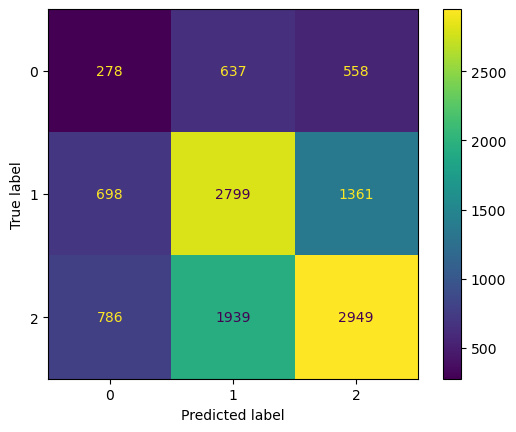

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 3

More powerful Network

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_70 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

In [ ]:
path_model = './new_models_sc/ex3_scratch_32_2x256_1024_dp_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.4118
Epoch 00001: val_loss improved from inf to 1.13862, saving model to ./new_models_sc\ex3_scratch_32_2x256_1024_dp_epoch_30_adam_1e-4.h5
940/940 [==============================] - 155s 145ms/step - loss: 1.0745 - accuracy: 0.4118 - val_loss: 1.1386 - val_accuracy: 0.3779
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.4552
Epoch 00002: val_loss improved from 1.13862 to 1.03285, saving model to ./new_models_sc\ex3_scratch_32_2x256_1024_dp_epoch_30_adam_1e-4.h5
940/940 [==============================] - 143s 137ms/step - loss: 1.0461 - accuracy: 0.4552 - val_loss: 1.0328 - val_accuracy: 0.4736
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.0244 - accuracy: 0.4784
Epoch 00003: val_loss improved from 1.03285 to 1.01844, saving model to ./new_models_sc\ex3_scratch_32_2x256_1024_dp_epoch_30_adam_1e-4.h5
940/940 [====================

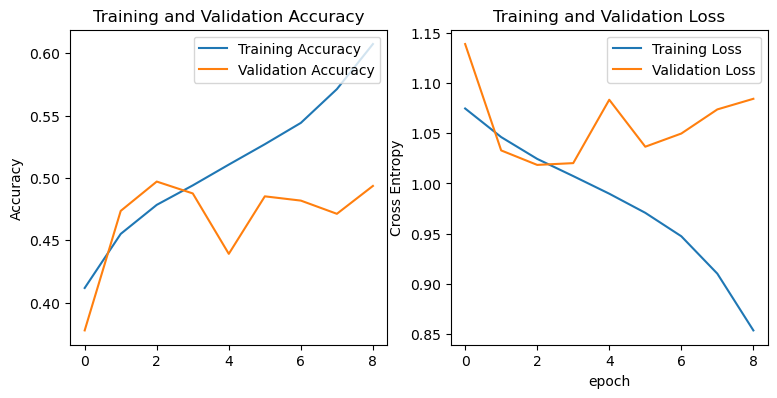

In [ ]:
show_history_fit(history)

188/188 [==============================] - 23s 49ms/step - loss: 1.0177 - accuracy: 0.4878
tf.Tensor([2 1 1 ... 0 1 2], shape=(12005,), dtype=int64)
tf.Tensor([1 1 1 ... 0 0 1], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1546    0.2064    0.1768      1473
           1     0.5241    0.4819    0.5021      4858
           2     0.5763    0.5659    0.5710      5674

    accuracy                         0.4878     12005
   macro avg     0.4183    0.4181    0.4166     12005
weighted avg     0.5034    0.4878    0.4948     12005



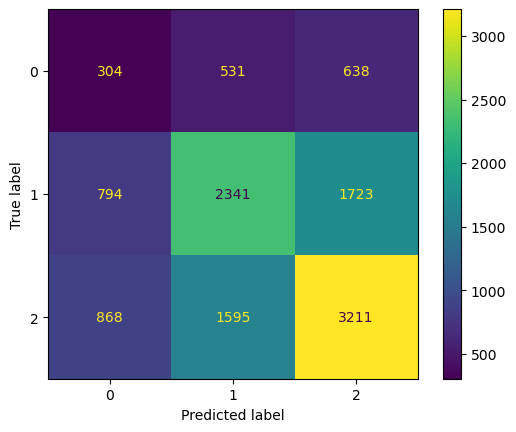

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 4

Insert GlobalAveragingPooling and Another dropout (to mitigate the overfit)

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

In [ ]:
path_model = './new_models_sc/ex4_scratch_32_2x256_1024_dpx2_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 1.0859 - accuracy: 0.3841
Epoch 00001: val_loss improved from inf to 1.06851, saving model to ./new_models_sc\ex4_scratch_32_2x256_1024_dpx2_epoch_30_adam_1e-4.h5
940/940 [==============================] - 143s 137ms/step - loss: 1.0859 - accuracy: 0.3841 - val_loss: 1.0685 - val_accuracy: 0.4295
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.0559 - accuracy: 0.4445
Epoch 00002: val_loss improved from 1.06851 to 1.06116, saving model to ./new_models_sc\ex4_scratch_32_2x256_1024_dpx2_epoch_30_adam_1e-4.h5
940/940 [==============================] - 143s 137ms/step - loss: 1.0559 - accuracy: 0.4445 - val_loss: 1.0612 - val_accuracy: 0.4459
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.0368 - accuracy: 0.4664
Epoch 00003: val_loss improved from 1.06116 to 1.04036, saving model to ./new_models_sc\ex4_scratch_32_2x256_1024_dpx2_epoch_30_adam_1e-4.h5
940/940 [==============

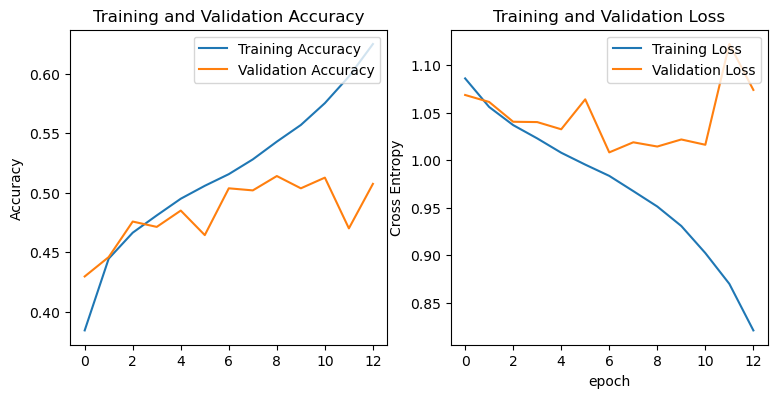

In [ ]:
show_history_fit(history)

188/188 [==============================] - 23s 51ms/step - loss: 1.0101 - accuracy: 0.5010
tf.Tensor([2 2 0 ... 1 2 2], shape=(12005,), dtype=int64)
tf.Tensor([2 2 0 ... 1 1 1], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1655    0.2335    0.1937      1473
           1     0.5340    0.5356    0.5348      4858
           2     0.6076    0.5411    0.5724      5674

    accuracy                         0.5011     12005
   macro avg     0.4357    0.4367    0.4336     12005
weighted avg     0.5235    0.5011    0.5107     12005



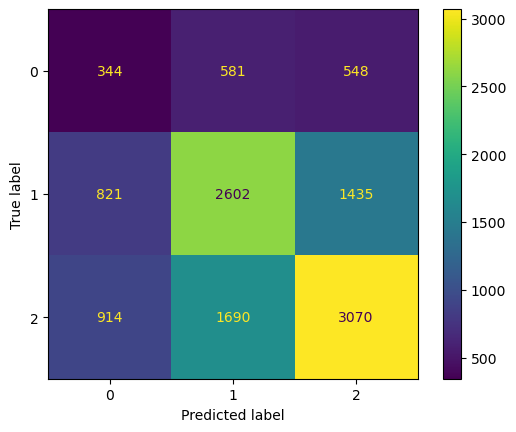

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 5

Dropout + Regularization (on Conv Layers)

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                       

In [ ]:
path_model = './new_models_sc/ex5_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 1.2281 - accuracy: 0.3890
Epoch 00001: val_loss improved from inf to 1.11783, saving model to ./new_models_sc\ex5_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-4.h5
940/940 [==============================] - 186s 160ms/step - loss: 1.2281 - accuracy: 0.3890 - val_loss: 1.1178 - val_accuracy: 0.3722
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.0799 - accuracy: 0.4298
Epoch 00002: val_loss improved from 1.11783 to 1.06810, saving model to ./new_models_sc\ex5_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-4.h5
940/940 [==============================] - 149s 143ms/step - loss: 1.0799 - accuracy: 0.4298 - val_loss: 1.0681 - val_accuracy: 0.4734
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.0683 - accuracy: 0.4415
Epoch 00003: val_loss did not improve from 1.06810
940/940 [==============================] - 150s 144ms/step - loss: 1.0683 - accuracy: 0.4415 

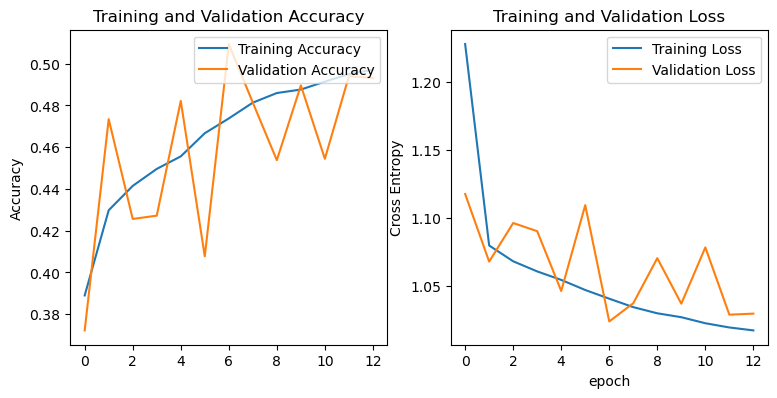

In [ ]:
show_history_fit(history)

188/188 [==============================] - 24s 54ms/step - loss: 1.0292 - accuracy: 0.4965
tf.Tensor([2 0 2 ... 1 2 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1472    0.1534    0.1503      1473
           1     0.5421    0.3991    0.4598      4858
           2     0.5506    0.6688    0.6040      5674

    accuracy                         0.4965     12005
   macro avg     0.4133    0.4071    0.4047     12005
weighted avg     0.4976    0.4965    0.4899     12005



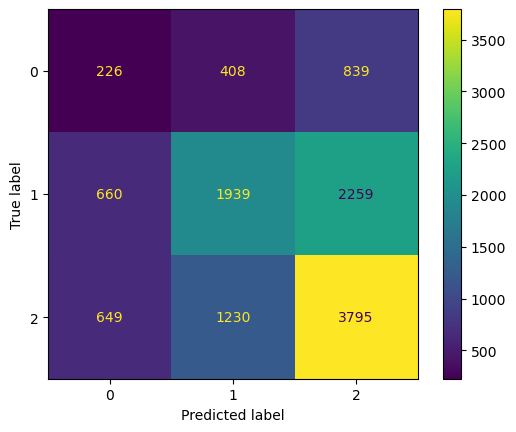

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 6

Remove some conv layers

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 128)     73856     
                                                             

In [ ]:
path_model = './new_models_sc/ex6_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 1.3874 - accuracy: 0.3763
Epoch 00001: val_loss improved from inf to 1.12552, saving model to ./new_models_sc\ex6_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 278s 270ms/step - loss: 1.3874 - accuracy: 0.3763 - val_loss: 1.1255 - val_accuracy: 0.5232
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.1014 - accuracy: 0.4021
Epoch 00002: val_loss improved from 1.12552 to 1.08160, saving model to ./new_models_sc\ex6_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 262s 263ms/step - loss: 1.1014 - accuracy: 0.4021 - val_loss: 1.0816 - val_accuracy: 0.5337
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.0887 - accuracy: 0.4143
Epoch 00003: val_loss did not improve from 1.08160
940/940 [==============================] - 258s 259ms/step - loss: 1.0887

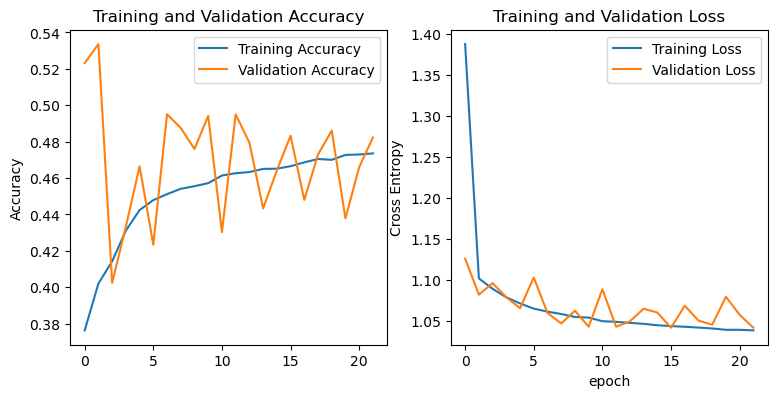

In [ ]:
show_history_fit(history)

188/188 [==============================] - 31s 86ms/step - loss: 1.0422 - accuracy: 0.4798
tf.Tensor([1 0 2 ... 1 1 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1661    0.2519    0.2002      1473
           1     0.5032    0.6303    0.5596      4858
           2     0.6311    0.4101    0.4972      5674

    accuracy                         0.4798     12005
   macro avg     0.4335    0.4308    0.4190     12005
weighted avg     0.5223    0.4798    0.4860     12005



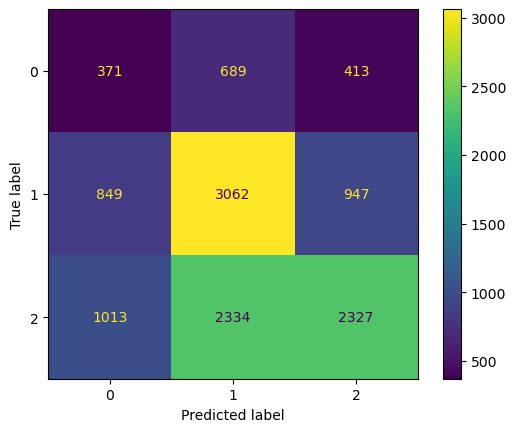

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 7

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 128)     73856     
                                                             

In [ ]:
path_model = './new_models_sc/ex7_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 2.5056 - accuracy: 0.3957
Epoch 00001: val_loss improved from inf to 2.19524, saving model to ./new_models_sc\ex7_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 297s 290ms/step - loss: 2.5056 - accuracy: 0.3957 - val_loss: 2.1952 - val_accuracy: 0.4358
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.9710 - accuracy: 0.4345
Epoch 00002: val_loss improved from 2.19524 to 1.85566, saving model to ./new_models_sc\ex7_scratch_32_2x256_1024_dpx2_regulariz_batchNorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 280s 281ms/step - loss: 1.9710 - accuracy: 0.4345 - val_loss: 1.8557 - val_accuracy: 0.3139
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.5996 - accuracy: 0.4482
Epoch 00003: val_loss improved from 1.85566 to 1.51651, saving model to ./new_models_sc\ex7_scratch_32_2x256_1024_dpx2_regul

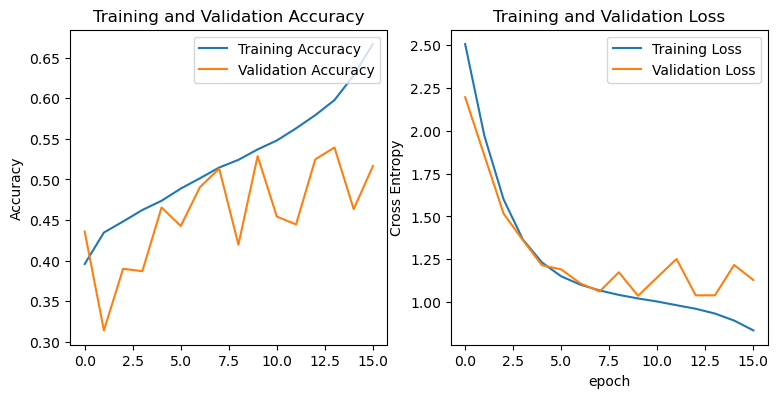

In [ ]:
show_history_fit(history)

188/188 [==============================] - 33s 94ms/step - loss: 1.0409 - accuracy: 0.5214
tf.Tensor([2 1 1 ... 1 0 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1707    0.1521    0.1609      1473
           1     0.5188    0.6581    0.5802      4858
           2     0.6264    0.5002    0.5562      5674

    accuracy                         0.5214     12005
   macro avg     0.4386    0.4368    0.4324     12005
weighted avg     0.5269    0.5214    0.5174     12005



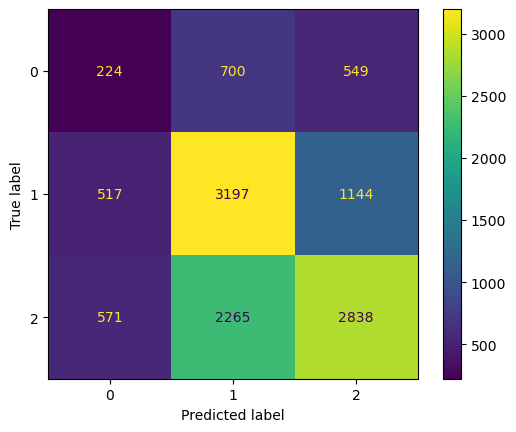

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 8

Provo la rete con 50 accuracy con regularization e altri metodi per mitigare l'overfitting

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

In [ ]:
path_model = './new_models_sc/ex8_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model)

Epoch 1/30
940/940 [==============================] - ETA: 0s - loss: 5.5645 - accuracy: 0.4334
Epoch 00001: val_loss improved from inf to 2.08843, saving model to ./new_models_sc\ex8_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 153s 140ms/step - loss: 5.5645 - accuracy: 0.4334 - val_loss: 2.0884 - val_accuracy: 0.4285
Epoch 2/30
940/940 [==============================] - ETA: 0s - loss: 1.4726 - accuracy: 0.4637
Epoch 00002: val_loss improved from 2.08843 to 1.26295, saving model to ./new_models_sc\ex8_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 179s 175ms/step - loss: 1.4726 - accuracy: 0.4637 - val_loss: 1.2629 - val_accuracy: 0.3987
Epoch 3/30
940/940 [==============================] - ETA: 0s - loss: 1.1155 - accuracy: 0.4817
Epoch 00003: val_loss improved from 1.26295 to 1.14148, saving model to ./new_models_sc\ex8_scratch_32_2x256_512_dp_regular_batchnorm_

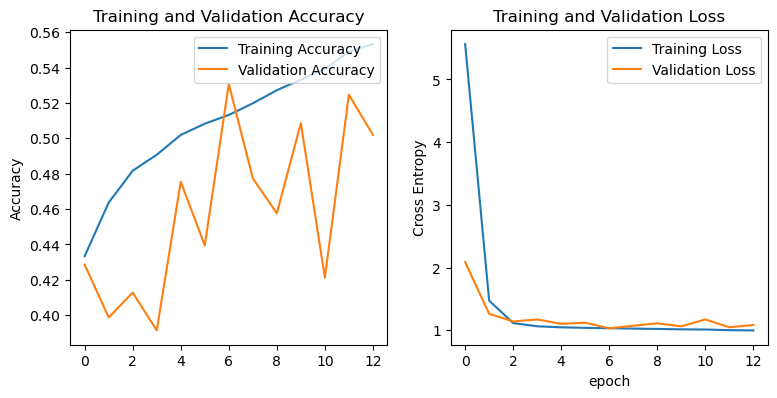

In [ ]:
show_history_fit(history)

188/188 [==============================] - 24s 52ms/step - loss: 1.0376 - accuracy: 0.5091
tf.Tensor([2 2 0 ... 1 0 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1529    0.1120    0.1293      1473
           1     0.5744    0.3242    0.4145      4858
           2     0.5342    0.7705    0.6310      5674

    accuracy                         0.5091     12005
   macro avg     0.4205    0.4023    0.3916     12005
weighted avg     0.5037    0.5091    0.4818     12005



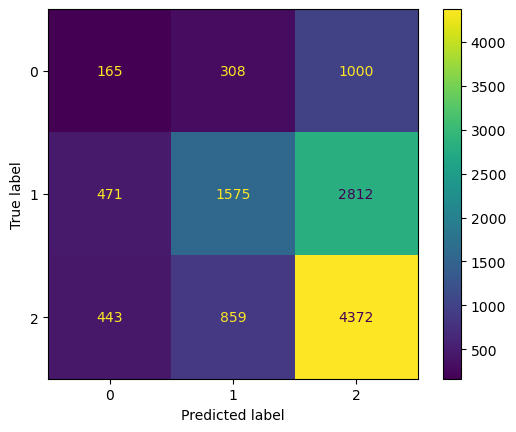

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 9

Provo la rete dell'esperimento 7 con una regularization diversa e un parametro di regolatization differente

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L1(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.001))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 128)     73856     
                                                             

In [ ]:
path_model = './new_models_sc/ex9_scratch_32_2x256_512_1024_dp_regularL1_batchnorm_epoch_35_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, 35, 10)

Epoch 1/35
940/940 [==============================] - ETA: 0s - loss: 19.9389 - accuracy: 0.3970
Epoch 00001: val_loss improved from inf to 3.95370, saving model to ./new_models_sc\ex9_scratch_32_2x256_512_1024_dp_regularL1_batchnorm_epoch_35_adam_1e-4.h5
940/940 [==============================] - 291s 285ms/step - loss: 19.9389 - accuracy: 0.3970 - val_loss: 3.9537 - val_accuracy: 0.5151
Epoch 2/35
940/940 [==============================] - ETA: 0s - loss: 2.1559 - accuracy: 0.4345
Epoch 00002: val_loss improved from 3.95370 to 1.37576, saving model to ./new_models_sc\ex9_scratch_32_2x256_512_1024_dp_regularL1_batchnorm_epoch_35_adam_1e-4.h5
940/940 [==============================] - 278s 279ms/step - loss: 2.1559 - accuracy: 0.4345 - val_loss: 1.3758 - val_accuracy: 0.4116
Epoch 3/35
940/940 [==============================] - ETA: 0s - loss: 1.2133 - accuracy: 0.4452
Epoch 00003: val_loss improved from 1.37576 to 1.20802, saving model to ./new_models_sc\ex9_scratch_32_2x256_512_1024_

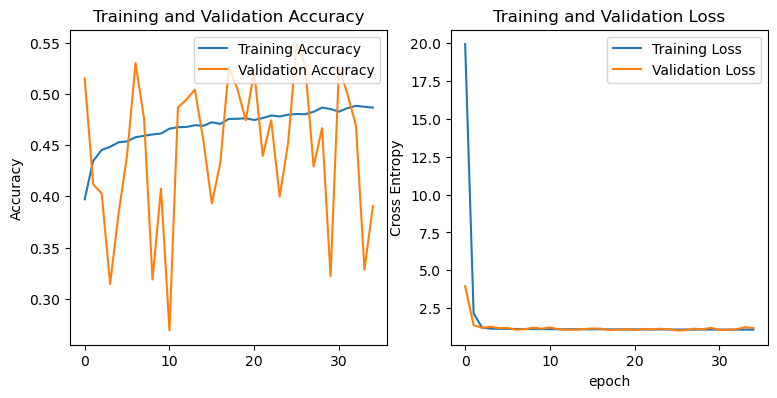

In [ ]:
show_history_fit(history)

188/188 [==============================] - 31s 88ms/step - loss: 1.0384 - accuracy: 0.5362
tf.Tensor([2 0 2 ... 1 1 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2015    0.0903    0.1247      1473
           1     0.5290    0.5733    0.5502      4858
           2     0.5788    0.6202    0.5988      5674

    accuracy                         0.5362     12005
   macro avg     0.4364    0.4279    0.4246     12005
weighted avg     0.5123    0.5362    0.5210     12005



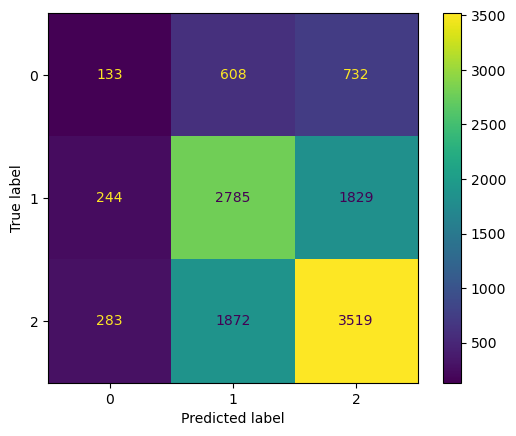

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

Provare ad allenare la rete dell'esperimento 8 però con una patience manggiore per vedere se la rete riesce a migliorare o a trovare una mappatura maggiore

### Experiment 10

In [ ]:
#clear from the previuos training
#from tensorflow.keras import backend as K
#del model
#K.clear_session()

In [ ]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [ ]:
compile_model(model, 'rmsprop', 0.0001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                       

In [ ]:
path_model = './new_models_sc/ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model, 35, 10)

Epoch 1/35
940/940 [==============================] - ETA: 0s - loss: 3.6007 - accuracy: 0.4360
Epoch 00001: val_loss improved from inf to 1.46366, saving model to ./new_models_sc\ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 153s 145ms/step - loss: 3.6007 - accuracy: 0.4360 - val_loss: 1.4637 - val_accuracy: 0.4142
Epoch 2/35
940/940 [==============================] - ETA: 0s - loss: 1.2184 - accuracy: 0.4771
Epoch 00002: val_loss improved from 1.46366 to 1.18759, saving model to ./new_models_sc\ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5
940/940 [==============================] - 159s 153ms/step - loss: 1.2184 - accuracy: 0.4771 - val_loss: 1.1876 - val_accuracy: 0.3935
Epoch 3/35
940/940 [==============================] - ETA: 0s - loss: 1.0832 - accuracy: 0.4907
Epoch 00003: val_loss improved from 1.18759 to 1.11438, saving model to ./new_models_sc\ex10_scratch_32_2x256_512_dp_regular_batchno

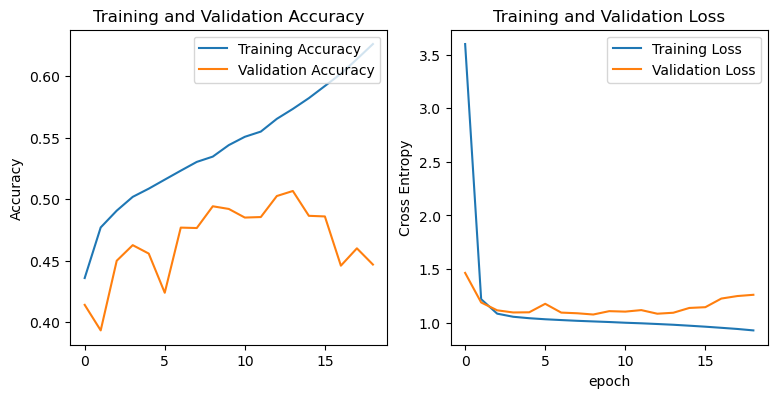

In [ ]:
show_history_fit(history)

188/188 [==============================] - 24s 53ms/step - loss: 1.0718 - accuracy: 0.4945
tf.Tensor([2 1 2 ... 1 0 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1680    0.2525    0.2018      1473
           1     0.5624    0.3841    0.4565      4858
           2     0.5716    0.6521    0.6092      5674

    accuracy                         0.4946     12005
   macro avg     0.4340    0.4296    0.4225     12005
weighted avg     0.5184    0.4946    0.4974     12005



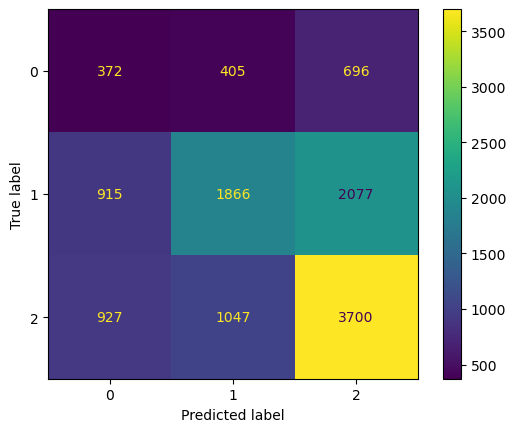

In [ ]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 11

Esperimenti vari

In [12]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
#x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [13]:
compile_model(model, 'adam', 0.00001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 24, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 24, 24, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 18, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 18, 18, 256)       295168    
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 18, 256)       590080

In [14]:
path_model = './new_models_sc/ex11_extra_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-5.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
235/235 [==============================] - ETA: 0s - loss: 7.8887 - accuracy: 0.3603
Epoch 00001: val_loss improved from inf to 7.05759, saving model to ./new_models_sc\ex11_extra_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-5.h5
235/235 [==============================] - 180s 700ms/step - loss: 7.8887 - accuracy: 0.3603 - val_loss: 7.0576 - val_accuracy: 0.4758
Epoch 2/40
235/235 [==============================] - ETA: 0s - loss: 6.3818 - accuracy: 0.3959
Epoch 00002: val_loss improved from 7.05759 to 5.73615, saving model to ./new_models_sc\ex11_extra_scratch_32_2x256_1024_dpx2_regulariz_epoch_30_adam_1e-5.h5
235/235 [==============================] - 159s 661ms/step - loss: 6.3818 - accuracy: 0.3959 - val_loss: 5.7362 - val_accuracy: 0.4471
Epoch 3/40
235/235 [==============================] - ETA: 0s - loss: 5.2292 - accuracy: 0.4139
Epoch 00003: val_loss improved from 5.73615 to 4.72381, saving model to ./new_models_sc\ex11_extra_scratch_32_2x256_1024_dpx2_regu

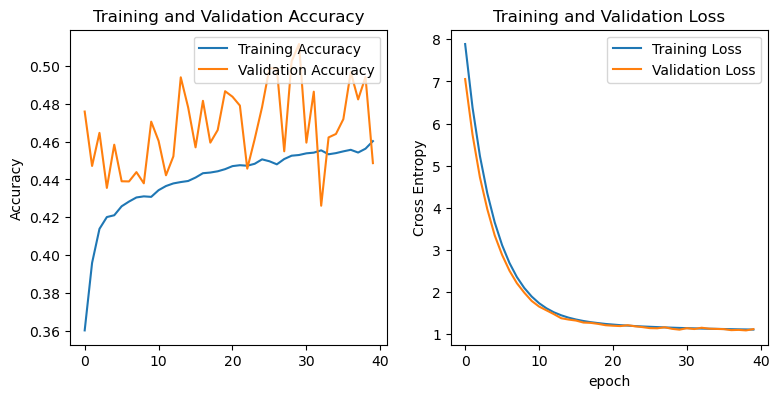

In [15]:
show_history_fit(history)

47/47 [==============================] - 20s 350ms/step - loss: 1.0949 - accuracy: 0.4886
tf.Tensor([2 1 2 ... 2 0 2], shape=(12005,), dtype=int64)
tf.Tensor([2 2 2 ... 1 2 1], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1627    0.2064    0.1819      1473
           1     0.5270    0.4726    0.4983      4858
           2     0.5651    0.5756    0.5703      5674

    accuracy                         0.4886     12005
   macro avg     0.4183    0.4182    0.4169     12005
weighted avg     0.5003    0.4886    0.4935     12005



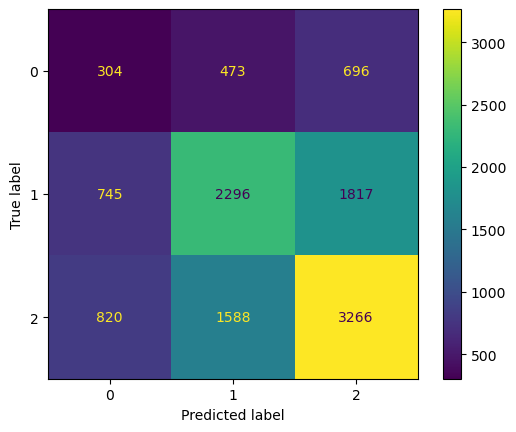

In [16]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 12

Uso rete esperimento 4 con aggiunta di un layer di batch normalizzation e regularization e un  dense layer in più

In [11]:
input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = layers.Rescaling(1./255)(input)
x = layers.Conv2D(32, (5, 5), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (4, 4), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L1L2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs = output)

In [12]:
compile_model(model, 'adam', 0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                         

In [13]:
path_model = './new_models_sc/ex12_scratch_32_2x256_1024_dpx2_regulariz_batch_moreDense_epoch_30_adam_1e-5.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
940/940 [==============================] - ETA: 0s - loss: 10.2613 - accuracy: 0.4077
Epoch 00001: val_loss improved from inf to 1.16270, saving model to ./new_models_sc\ex12_scratch_32_2x256_1024_dpx2_regulariz_batch_moreDense_epoch_30_adam_1e-5.h5
940/940 [==============================] - 245s 234ms/step - loss: 10.2613 - accuracy: 0.4077 - val_loss: 1.1627 - val_accuracy: 0.3176
Epoch 2/40
940/940 [==============================] - ETA: 0s - loss: 1.0981 - accuracy: 0.4378
Epoch 00002: val_loss improved from 1.16270 to 1.04159, saving model to ./new_models_sc\ex12_scratch_32_2x256_1024_dpx2_regulariz_batch_moreDense_epoch_30_adam_1e-5.h5
940/940 [==============================] - 252s 239ms/step - loss: 1.0981 - accuracy: 0.4378 - val_loss: 1.0416 - val_accuracy: 0.5215
Epoch 3/40
940/940 [==============================] - ETA: 0s - loss: 1.0860 - accuracy: 0.4525
Epoch 00003: val_loss did not improve from 1.04159
940/940 [==============================] - 253s 254ms/ste

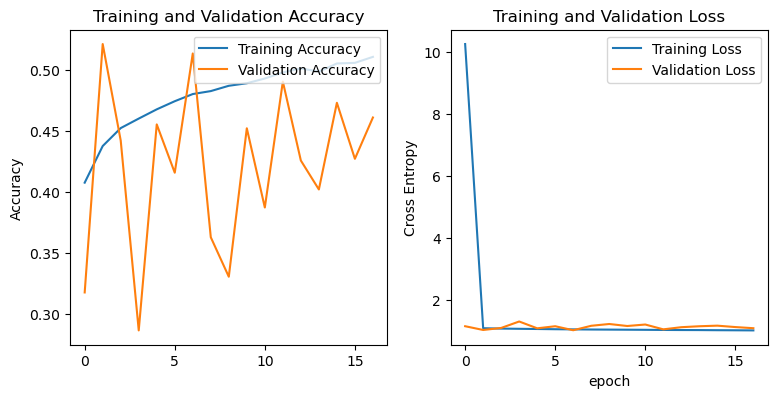

In [14]:
show_history_fit(history)

188/188 [==============================] - 24s 56ms/step - loss: 1.0354 - accuracy: 0.5018
tf.Tensor([1 0 1 ... 1 1 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1474    0.0876    0.1099      1473
           1     0.4793    0.7262    0.5775      4858
           2     0.6279    0.4172    0.5013      5674

    accuracy                         0.5018     12005
   macro avg     0.4182    0.4103    0.3962     12005
weighted avg     0.5088    0.5018    0.4841     12005



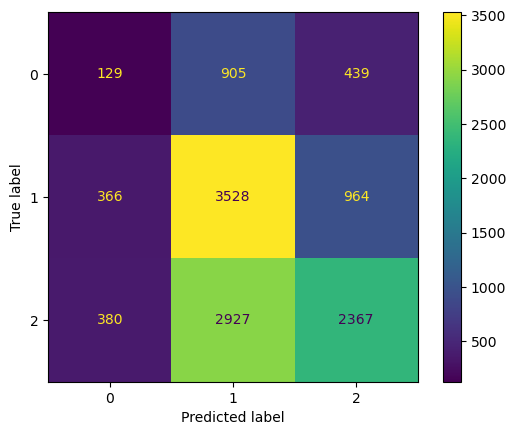

In [15]:
load_best_model_and_evaluate(path_model, test_ds)

## Pre-Trained Networks

### VGG16

#### Experiment 1

In [11]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
        weights='imagenet',  # load the network pretrained on ImageNet1K
        include_top=False)
        
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
LR = 0.0001
compile_model(model, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [14]:
path_model = './new_models_sc/pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1e-4.h5'
history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
940/940 [==============================] - ETA: 0s - loss: 1.6484 - accuracy: 0.4422
Epoch 00001: val_loss improved from inf to 1.10482, saving model to ./new_models_sc\pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1e-4.h5
940/940 [==============================] - 236s 225ms/step - loss: 1.6484 - accuracy: 0.4422 - val_loss: 1.1048 - val_accuracy: 0.4635
Epoch 2/40
940/940 [==============================] - ETA: 0s - loss: 1.0495 - accuracy: 0.5033
Epoch 00002: val_loss improved from 1.10482 to 1.03694, saving model to ./new_models_sc\pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1e-4.h5
940/940 [==============================] - 217s 214ms/step - loss: 1.0495 - accuracy: 0.5033 - val_loss: 1.0369 - val_accuracy: 0.4949
Epoch 3/40
940/940 [==============================] - ETA: 0s - loss: 0.9771 - accuracy: 0.5394
Epoch 00003: val_loss improved from 1.03694 to 1.03217, saving model to ./new_models_sc\pretrained_vgg16_no_tuning_512_dp_epoch_40_adam_1e-4.h5
940/940 [=====

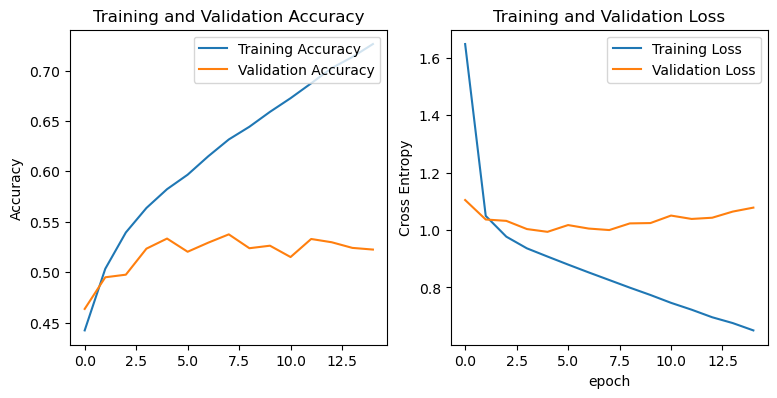

In [15]:
show_history_fit(history)

188/188 [==============================] - 46s 165ms/step - loss: 0.9963 - accuracy: 0.5292
tf.Tensor([1 0 1 ... 1 0 2], shape=(12005,), dtype=int64)
tf.Tensor([2 1 2 ... 1 2 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1746    0.2267    0.1973      1473
           1     0.5586    0.5916    0.5746      4858
           2     0.6357    0.5543    0.5922      5674

    accuracy                         0.5292     12005
   macro avg     0.4563    0.4575    0.4547     12005
weighted avg     0.5479    0.5292    0.5366     12005



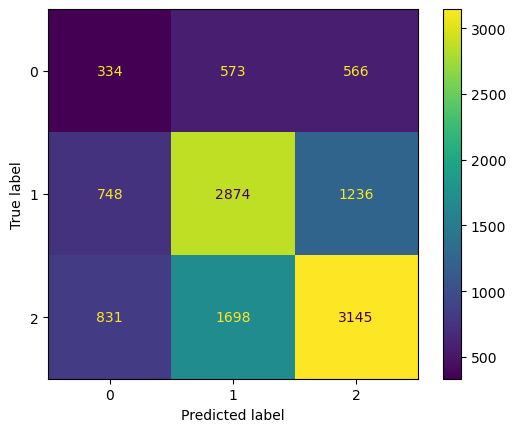

In [16]:
load_best_model_and_evaluate(path_model, test_ds)

#### Experiment 2

In [17]:
model_finetune = tf.keras.models.load_model(path_model)
model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [18]:
model_finetune.trainable = True

base_model_vgg16 = model_finetune.get_layer("vgg16") # change the name looking at the summary IMPORTANT!
print("Number of layers in the base model: ", len(base_model_vgg16.layers))
base_model_vgg16.summary()

Number of layers in the base model:  19
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPool

In [19]:
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block4_conv1': # è buona pratica indicare da dove si parte a sfreezare la rete
        set_trainable = True
    if set_trainable: # fine a che la variabile booleana è a False allora setto i layer non traininabili altrimenti li setto come trainabili
        layer.trainable = True
    else:
        layer.trainable = False



model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [20]:
compile_model(model_finetune, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [21]:
path_model_tuned = './new_models_sc/pretrained_vgg16_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5'
history_tune, model_fitted_tuned = fit_model(model_finetune, train_ds, val_ds, path_model_tuned,40,10)

Epoch 1/40
940/940 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.5124
Epoch 00001: val_loss improved from inf to 1.00435, saving model to ./new_models_sc\pretrained_vgg16_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5
940/940 [==============================] - 313s 315ms/step - loss: 0.9891 - accuracy: 0.5124 - val_loss: 1.0043 - val_accuracy: 0.5113
Epoch 2/40
940/940 [==============================] - ETA: 0s - loss: 0.9092 - accuracy: 0.5738
Epoch 00002: val_loss did not improve from 1.00435
940/940 [==============================] - 324s 314ms/step - loss: 0.9092 - accuracy: 0.5738 - val_loss: 1.0353 - val_accuracy: 0.5188
Epoch 3/40
940/940 [==============================] - ETA: 0s - loss: 0.8575 - accuracy: 0.6059
Epoch 00003: val_loss improved from 1.00435 to 0.96836, saving model to ./new_models_sc\pretrained_vgg16_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5
940/940 [==============================] - 325s 315ms/step - loss: 0.8575 - a

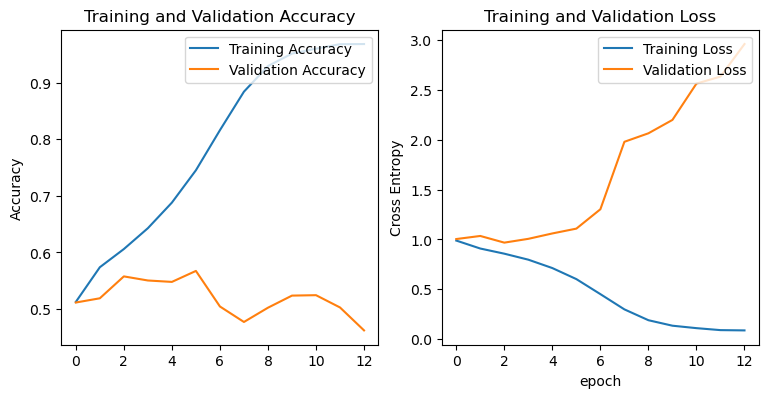

In [22]:
show_history_fit(history_tune)

188/188 [==============================] - 45s 155ms/step - loss: 0.9682 - accuracy: 0.5499
tf.Tensor([1 2 1 ... 0 1 1], shape=(12005,), dtype=int64)
tf.Tensor([2 2 1 ... 1 1 2], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1806    0.1439    0.1602      1473
           1     0.5416    0.6616    0.5956      4858
           2     0.6486    0.5597    0.6009      5674

    accuracy                         0.5499     12005
   macro avg     0.4569    0.4551    0.4522     12005
weighted avg     0.5479    0.5499    0.5447     12005



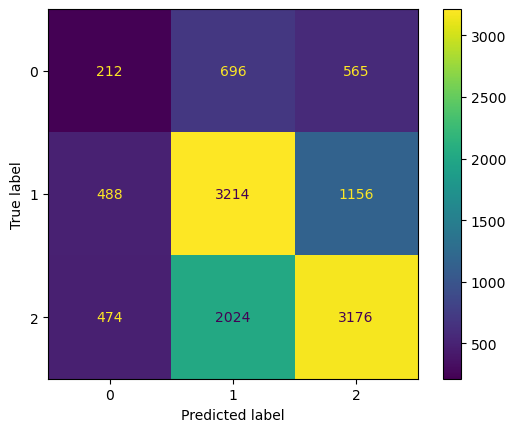

In [23]:
load_best_model_and_evaluate(path_model_tuned, test_ds)

### Experiment 3: uso batch più piccolo ma dimensioni immagini più grandi

In [11]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
        weights='imagenet',  # load the network pretrained on ImageNet1K
        include_top=False)
        
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 380, 380, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 380, 380, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 190, 190, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 190, 190, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 190, 190, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 95, 95, 128)       0     

In [12]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
LR = 0.0001

In [13]:

compile_model(model, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 380, 380, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 380, 380, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [11]:
path_model = './new_models_sc/pretrained_vgg16(400x400)_no_tuning_512_dp_epoch_40_adam_1e-4.h5'

In [14]:

#history, model_fitted = fit_model(model, train_ds, val_ds, path_model,40,10)

Epoch 1/40
1879/1879 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.4705
Epoch 00001: val_loss improved from inf to 0.99081, saving model to ./new_models_sc\pretrained_vgg16(400x400)_no_tuning_512_dp_epoch_40_adam_1e-4.h5
1879/1879 [==============================] - 593s 309ms/step - loss: 1.2194 - accuracy: 0.4705 - val_loss: 0.9908 - val_accuracy: 0.5309
Epoch 2/40
1879/1879 [==============================] - ETA: 0s - loss: 0.9778 - accuracy: 0.5353
Epoch 00002: val_loss improved from 0.99081 to 0.97795, saving model to ./new_models_sc\pretrained_vgg16(400x400)_no_tuning_512_dp_epoch_40_adam_1e-4.h5
1879/1879 [==============================] - 530s 282ms/step - loss: 0.9778 - accuracy: 0.5353 - val_loss: 0.9780 - val_accuracy: 0.5429
Epoch 3/40
1879/1879 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.5625
Epoch 00003: val_loss improved from 0.97795 to 0.96366, saving model to ./new_models_sc\pretrained_vgg16(400x400)_no_tuning_512_dp

KeyboardInterrupt: 

In [ ]:
show_history_fit(history)

376/376 [==============================] - 90s 236ms/step - loss: 0.9723 - accuracy: 0.5441
tf.Tensor([2 2 2 ... 2 2 1], shape=(12005,), dtype=int64)
tf.Tensor([1 2 2 ... 2 2 1], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.1839    0.2159    0.1986      1473
           1     0.6012    0.5031    0.5478      4858
           2     0.6070    0.6644    0.6344      5674

    accuracy                         0.5441     12005
   macro avg     0.4640    0.4611    0.4603     12005
weighted avg     0.5527    0.5441    0.5459     12005



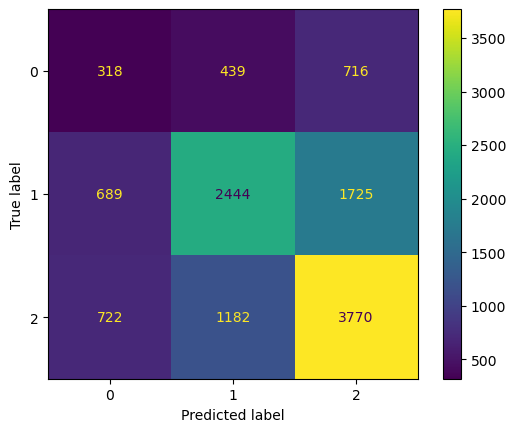

In [17]:
load_best_model_and_evaluate(path_model, test_ds)

### Experiment 4: come prima ma faccio il finetuning

In [12]:
model_finetune = tf.keras.models.load_model(path_model)
model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 380, 380, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 380, 380, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [13]:
model_finetune.trainable = True

base_model_vgg16 = model_finetune.get_layer("vgg16") # change the name looking at the summary IMPORTANT!
print("Number of layers in the base model: ", len(base_model_vgg16.layers))
base_model_vgg16.summary()

Number of layers in the base model:  19
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 380, 380, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 380, 380, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 190, 190, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 190, 190, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 190, 190, 128)     147584    
                                                                 
 block2_pool (MaxPool

In [14]:
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block4_conv1': # è buona pratica indicare da dove si parte a sfreezare la rete
        set_trainable = True
    if set_trainable: # fine a che la variabile booleana è a False allora setto i layer non traininabili altrimenti li setto come trainabili
        layer.trainable = True
    else:
        layer.trainable = False



model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 380, 380, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 380, 380, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [17]:
compile_model(model_finetune, 'adam', LR)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 380, 380, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 380, 380, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656

In [18]:
path_model_tuned = './new_models_sc/pretrained_vgg16(400x400)_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5'
history_tune, model_fitted_tuned = fit_model(model_finetune, train_ds, val_ds, path_model_tuned,40,10)

Epoch 1/40
1879/1879 [==============================] - ETA: 0s - loss: 1.0559 - accuracy: 0.4357
Epoch 00001: val_loss improved from inf to 0.96113, saving model to ./new_models_sc\pretrained_vgg16(400x400)_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5
1879/1879 [==============================] - 1187s 622ms/step - loss: 1.0559 - accuracy: 0.4357 - val_loss: 0.9611 - val_accuracy: 0.5479
Epoch 2/40
1879/1879 [==============================] - ETA: 0s - loss: 0.9755 - accuracy: 0.5254
Epoch 00002: val_loss did not improve from 0.96113
1879/1879 [==============================] - 771s 410ms/step - loss: 0.9755 - accuracy: 0.5254 - val_loss: 1.0877 - val_accuracy: 0.4626
Epoch 3/40
1879/1879 [==============================] - ETA: 0s - loss: 0.9178 - accuracy: 0.5641
Epoch 00003: val_loss did not improve from 0.96113
1879/1879 [==============================] - 779s 414ms/step - loss: 0.9178 - accuracy: 0.5641 - val_loss: 0.9743 - val_accuracy: 0.5434
Epoch 4/40
1879/1879 [======

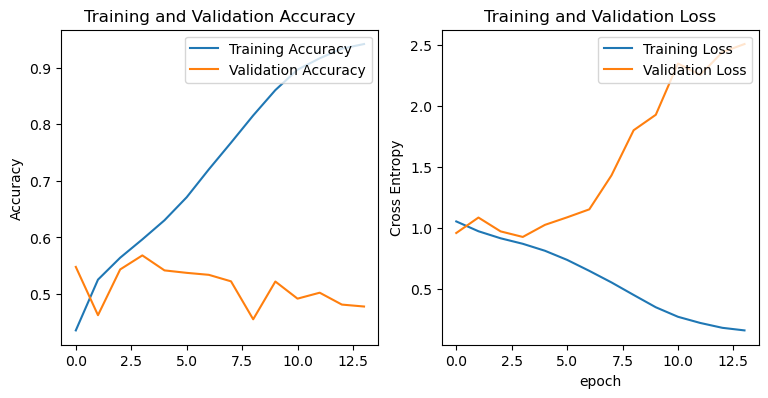

In [19]:
show_history_fit(history_tune)

376/376 [==============================] - 94s 231ms/step - loss: 0.9313 - accuracy: 0.5688
tf.Tensor([2 1 2 ... 2 2 1], shape=(12005,), dtype=int64)
tf.Tensor([1 2 2 ... 2 2 1], shape=(12005,), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     0.2112    0.0462    0.0758      1473
           1     0.5345    0.7023    0.6070      4858
           2     0.6318    0.5901    0.6102      5674

    accuracy                         0.5688     12005
   macro avg     0.4592    0.4462    0.4310     12005
weighted avg     0.5408    0.5688    0.5433     12005



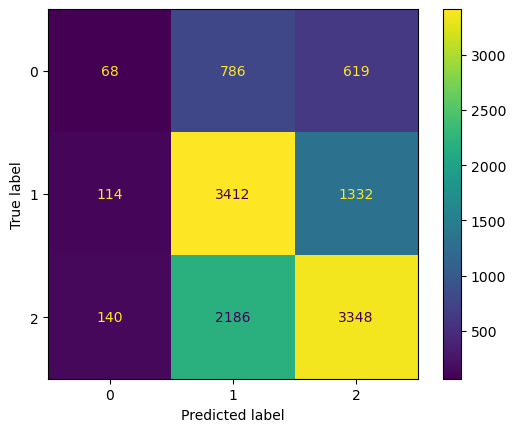

In [11]:
path_model_tuned = './new_models_sc/pretrained_vgg16(400x400)_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5'
load_best_model_and_evaluate(path_model_tuned, test_ds)